In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib.cm as cm
import time,os,subprocess
import copy
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
import scipy.interpolate as interpolate
import pyart.graph.cm as pcm
import cPickle as pickle
import datetime
import pyproj
import scipy.ndimage as ndi
import mahotas,pymorph,pylab
import pims
import trackpy as tp
from PIL import Image
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine
%matplotlib inline

## Tracking KDP/ZDR columns in Houston NEXRAD data using TrackPy
We will follow on the techniques used in kdp_cell_tracker.ipynb, with the following innovations:
- We will use KDP and ZDR "potential energy" which is $K_{DP}*h $, where h is height
- We now use new version of trackpy (maybe this is a pain in the ass)
- We are older and wiser nowaday

The motivation behind KDP and ZDR "potential energy" is as follows: we are concerned not only with the height of KDP/ZDR columns, but with the values of KDP/ZDR within them (and maybe this is more true for KDP than ZDR). 

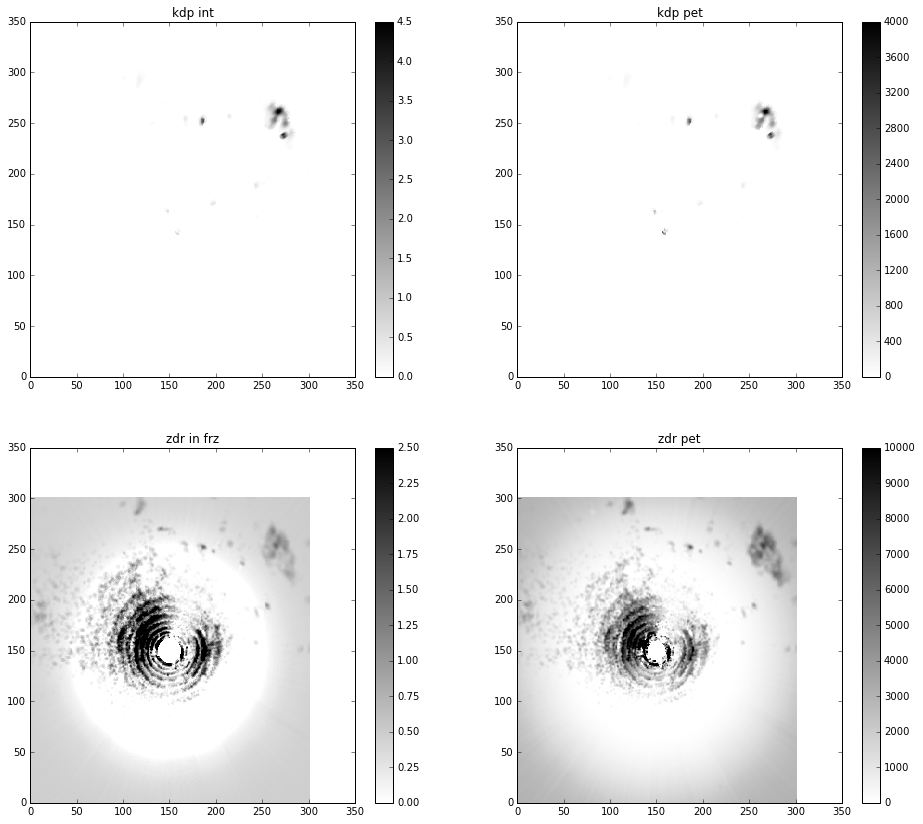

In [3]:
#..First let's consider *how* exactly we will identify these objects. We will attempt to use "KDP potential energy"
#..to identify these features. Let us start by looking at a single, suggestive time from KHGX
filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/grid00_khgx_20130619_180311.nc'
#filenm = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/grid00_khgx_20130608_202447.nc'
khgx_lat = 29.468
khgx_lon = -95.075
radr_lat = khgx_lat
radr_lon = khgx_lon

zsfc = 35.   #..m (= 115 feet)
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
zhh = nc.variables['reflectivity'][0,:,:,:]
zdr = nc.variables['differential_reflectivity'][0,:,:,:]
kdp = nc.variables['kdp'][0,:,:,:]
rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
nc.close()

#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]

#..
zdr_proc = copy.deepcopy(zdr)
zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
kdp_proc = copy.deepcopy(kdp)
kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
#kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

vol_ones = zdr_proc*0.+1
kdp_pe = kdp_proc*zgrid
zdr_pe = zdr_proc*zgrid
kdp_pet = kdp_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
zdr_pet = zdr_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)


#..Plot
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(221)
aa = ax.pcolormesh(kdp_int[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4.5)
plt.title('kdp int')
plt.colorbar(aa)
ax = fig.add_subplot(222)
ab = ax.pcolormesh(kdp_pet[50:351,50:351],cmap=cm.gray_r,vmin=0,vmax=4000.)
plt.colorbar(ab)
plt.title('kdp pet')
ax = fig.add_subplot(223)
ba = ax.pcolormesh(zdr[11,50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=2.5)
plt.colorbar(ba)
plt.title('zdr in frz')
ax = fig.add_subplot(224)
bb = ax.pcolormesh(zdr_pet[50:351,50:351],cmap=cm.gray_r,vmin=0.,vmax=10000)
plt.colorbar(bb)
plt.title('zdr pet')
#..

In [4]:
def normalize_array(array_in,minval=0,maxval=255,integerout=True,invert=False):
    array_out = copy.deepcopy(array_in)
    array_out[array_out<0.] = 0.  #..Here is subzero, now plain zero
    #..we lazily assume the minimum is zero...
    array_out = maxval*array_out/(array_out.max())
    if integerout:
        array_out = array_out.astype(np.uint8)
    if invert:
        array_out = maxval-array_out
    return array_out

In [5]:
#..Now let's do some funky stuff
kdp_proca = copy.deepcopy(kdp)
kdp_proca[kdp_proca==-9999.] = 0.
kdp_proca[rho<.8] = 0.
kdp_proca[zhh<15.] = 0.
kdp_pe = kdp_proca*zgrid
kdp_pet = kdp_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)

kdp_pet[kdp_pet>3000.]=3000.


zdr_temp = copy.deepcopy(zdr_pet)
zdr_temp[zdr_temp>10000.]=10000.
zhh_temp = copy.deepcopy(zhh)
#zhh_temp = zhh_temp*0.
zdr_pet_proc = normalize_array(zdr_temp,invert=False)
kdp_pet_proc = normalize_array(kdp_pet,invert=False)
zhh_pet_proc = normalize_array(zhh_temp[11,:,:],invert=False)

(400, 400, 3)


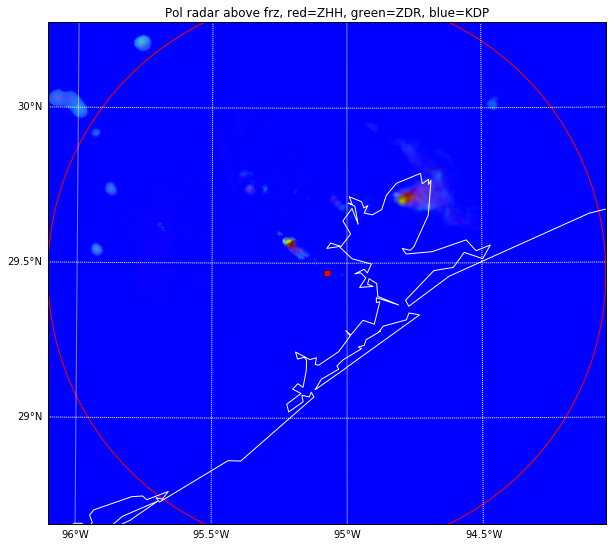

In [217]:
imag = np.dstack(((zhh_pet_proc/1.5).astype(np.uint8),zdr_pet_proc,kdp_pet_proc))
print imag.shape
img = Image.fromarray(imag,'RGB')
fig=plt.figure(figsize=(10,9))
m = Basemap(width=200000,height=180000,projection='lcc',
                resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.)
parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
#m.bluemarble()
#m.shadedrelief()
#m.etopo()

m.imshow(img)
m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
m.drawparallels(parallels,color='w',labels=[True,False,False,False])
m.drawmeridians(meridians,color='w',labels=[False,False,False,True])
m.drawstates(color='w')
m.drawcoastlines(color='w')
plt.title('Pol radar above frz, red=ZHH, green=ZDR, blue=KDP')

fig.savefig('test.png',dpi=150)

In [374]:
#..Let's loop over this crap
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
radfile_start = 'grid00_khgx'
numfiles = 0
radfiles = []
for root,dirs,files in walklevel(nexrad_path,level=0):
    for file in files:
        if file.startswith(radfile_start):
            radfiles.append(file)
            numfiles += 1
#print radfiles
radfiles = sorted(radfiles)
filenm = radfiles[0]

#..Loop
for i in xrange(numfiles):
    filenm =nexrad_path+radfiles[i]
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    zhh = nc.variables['reflectivity'][0,:,:,:]
    zdr = nc.variables['differential_reflectivity'][0,:,:,:]
    kdp = nc.variables['kdp'][0,:,:,:]
    rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
    nc.close()

    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    
    #..
    zdr_proc = copy.deepcopy(zdr)
    zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
    zdr_proc[zhh<5.]=0.
    #zdr_proc = np.ma.masked_where(zhh<5.,zdr_proc)
    kdp_proc = copy.deepcopy(kdp)
    kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
    kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
    kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

    vol_ones = zdr_proc*0.+1
    zdr_pe = zdr_proc*zgrid
    zdr_pet = zdr_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)

    kdp_proca = copy.deepcopy(kdp)
    kdp_proca[kdp_proca==-9999.] = 0.
    kdp_proca[rho<.8] = 0.
    kdp_proca[zhh<15.] = 0.
    kdp_pe = kdp_proca*zgrid
    kdp_pet = kdp_pe[9:17,:,:].sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)

    kdp_pet[kdp_pet>3000.]=3000.


    zdr_temp = copy.deepcopy(zdr_pet)
    zdr_temp[zdr_temp>10000.]=10000.
    zhh_temp = copy.deepcopy(zhh)
    #zhh_temp = zhh_temp*0.
    zdr_pet_proc = normalize_array(zdr_temp,invert=False)
    kdp_pet_proc = normalize_array(kdp_pet,invert=False)
    zhh_pet_proc = normalize_array(zhh_temp[11,:,:],invert=False)
    
    #..
    imag = np.dstack(((zhh_pet_proc/1.5).astype(np.uint8),zdr_pet_proc,kdp_pet_proc))
    img = Image.fromarray(imag,'RGB')
    fig=plt.figure(figsize=(8,7))
    m = Basemap(width=200000,height=180000,projection='lcc',
                    resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.)
    parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
    meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
    #m.bluemarble()
    #m.shadedrelief()
    #m.etopo()

    m.imshow(img)
    m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
    m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
    m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
    m.drawparallels(parallels,color='w',labels=[True,False,False,False])
    m.drawmeridians(meridians,color='w',labels=[False,False,False,True])
    m.drawstates(color='w')
    m.drawcoastlines(color='w')
    plt.title('Pol radar above frz, red=ZHH, green=ZDR, blue=KDP')

    fig.savefig('/home/mvanlier/mvanlier/plot_dump/houston_colorized/khgx_color_20110619_'+
                str(i).zfill(3)+'.png',dpi=100)
    fig.clf()
    plt.close(fig)

KeyboardInterrupt: 

### Moving on to implementation of feature ID and tracking
We will go forward with kdp_pe, even though it does not seem to offer an obvious advantage over kdp_int. We make this choice because this metric makes *more sense*. The main thing is getting trackpy to read it. 


We will do this as a start, and maybe do something fancy with ZDR later. To use ZDR, it may be necessary to use image processing to remove the background (see here: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html#example-color-exposure-plot-regional-maxima-py  or here: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_threshold_adaptive.html#example-segmentation-plot-threshold-adaptive-py )

The way to do this is: load and processing data as numpy arrays, save in a temp file as tiff images, use trackpy to load tiff and track tiff images. Then use the tracks from trackpy with numpy arrays to do all the analysis. 

In [8]:
print 'test'

test


### First, process files into TIFF images of "KDP potential energy"

In [6]:
#..Get a list of radar data files. 
#nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
radfile_start = 'grid00_khgx'
numfiles = 0
radfiles = []
for root,dirs,files in walklevel(nexrad_path,level=0):
    for file in files:
        if file.startswith(radfile_start):
            radfiles.append(file)
            numfiles += 1
#print radfiles
radfiles = sorted(radfiles)
filenm = radfiles[0]

#..Load up things that don't change file-by-file
filenm = nexrad_path+radfiles[0]
nc = Dataset(filenm,'r')
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
zd = nc.variables['z_disp'][:]
#..Make vectors of cell edges
xe = make_edge_vec(xd)
ye = make_edge_vec(yd)
ze = make_edge_vec(zd)
alt= zd + zsfc
alte=ze + zsfc
#..Get lat/lon from dx,dy
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
zgrid = np.zeros((len(zd),len(yd),len(xd)))
for j in range(len(zd)):
    zgrid[j,:,:] = zd[j]
nc.close()

#..Loop and load and analyze radar data to get kdp potential energy
for i in xrange(numfiles):
    filenm =nexrad_path+radfiles[i]
    nc = Dataset(filenm,'r')
    zhh = nc.variables['reflectivity'][0,:,:,:]
    zdr = nc.variables['differential_reflectivity'][0,:,:,:]
    kdp = nc.variables['kdp'][0,:,:,:]
    rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
    nc.close()

    kdp_proc = copy.deepcopy(kdp)
    kdp_proc[rho<.8] = 0.
    kdp_proc[zhh<15.] = 0.
    kdp_proc[kdp_proc==-9999.] = 0.
    #kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
    #kdp_proc = np.ma.masked_where(rho<.8,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
    #kdp_proc = np.ma.masked_where(zhh<20.,kdp_proc)
    #kdp_int = kdp_proc[9:15,:,:].sum(axis=0)

    vol_ones = kdp_proc*0.+1
    kdp_pet = (zgrid[9:17,:,:]*kdp_proc[9:17,:,:]).sum(axis=0)/vol_ones[9:17,:,:].sum(axis=0)
    kdp_pet[kdp_pet>3000.]=3000.

    kdp_pet_proc = normalize_array(kdp_pet,invert=True)
    
    #..
    img = Image.fromarray(kdp_pet_proc)
    img.save('temp2/kdp_pe_'+str(i).zfill(3)+'.tiff')

### Now load one of these images to fine-tune detection

In [7]:
#frames = pims.ImageSequence('temp/*.tiff', as_grey=True)
frames = pims.ImageSequence('temp2/*.tiff', as_grey=True)
#..

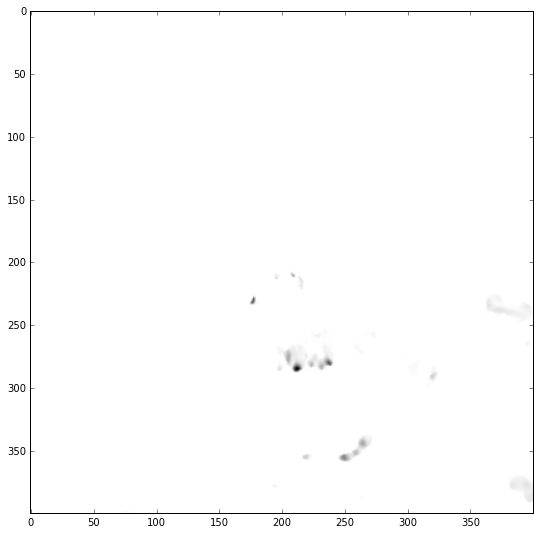

In [8]:
plt.figure(figsize=(10,9))
plt.imshow(frames[87],cmap=cm.gray)

In [9]:
f = tp.locate(frames[87], 11, invert=True)

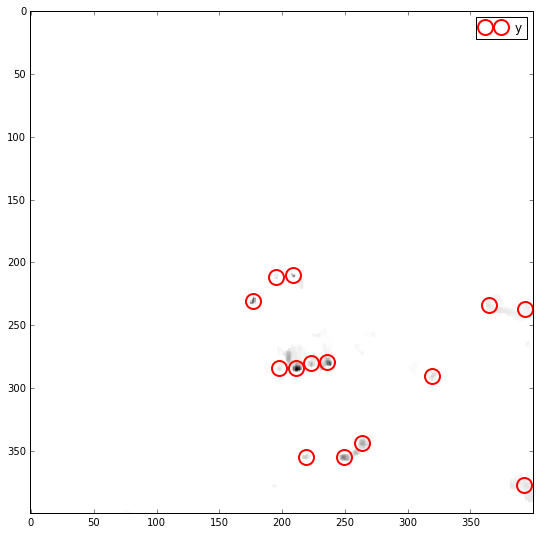

In [10]:
plt.figure(figsize=(10,9))  # make a new figure
tp.annotate(f, frames[87])

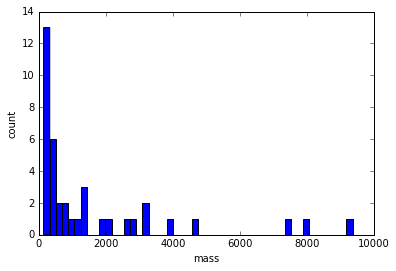

In [380]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

In [11]:
#..Locate features in all frames
f = tp.batch(frames[:], 11, invert=True)

Frame 114: 12 features


In [382]:
# 9 is about 30m/s
#..Link features into trajectories
t = tp.link_df(f, 9, memory=3)

Frame 118: 9 trajectories present


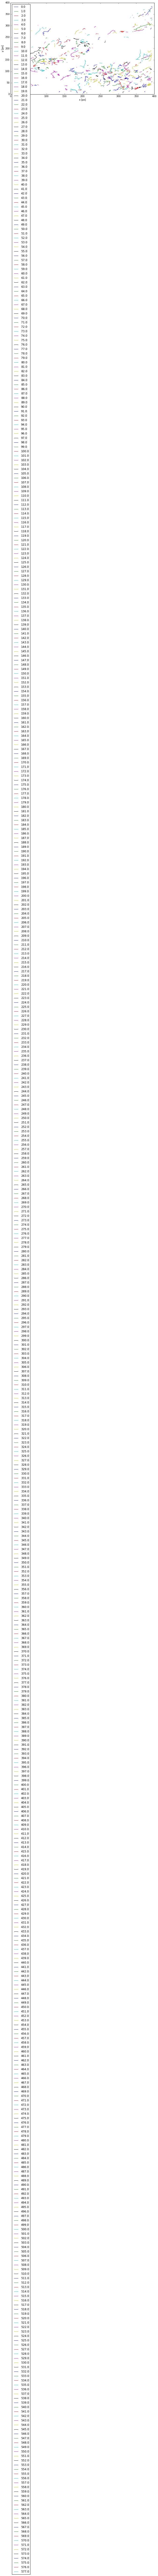

In [383]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t)
#ax = plt.gca()
ax.legend_.remove()
#ax.legend_ = None
#draw()

In [384]:
t1 = tp.filter_stubs(t, 6)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 578)
('After:', 193)


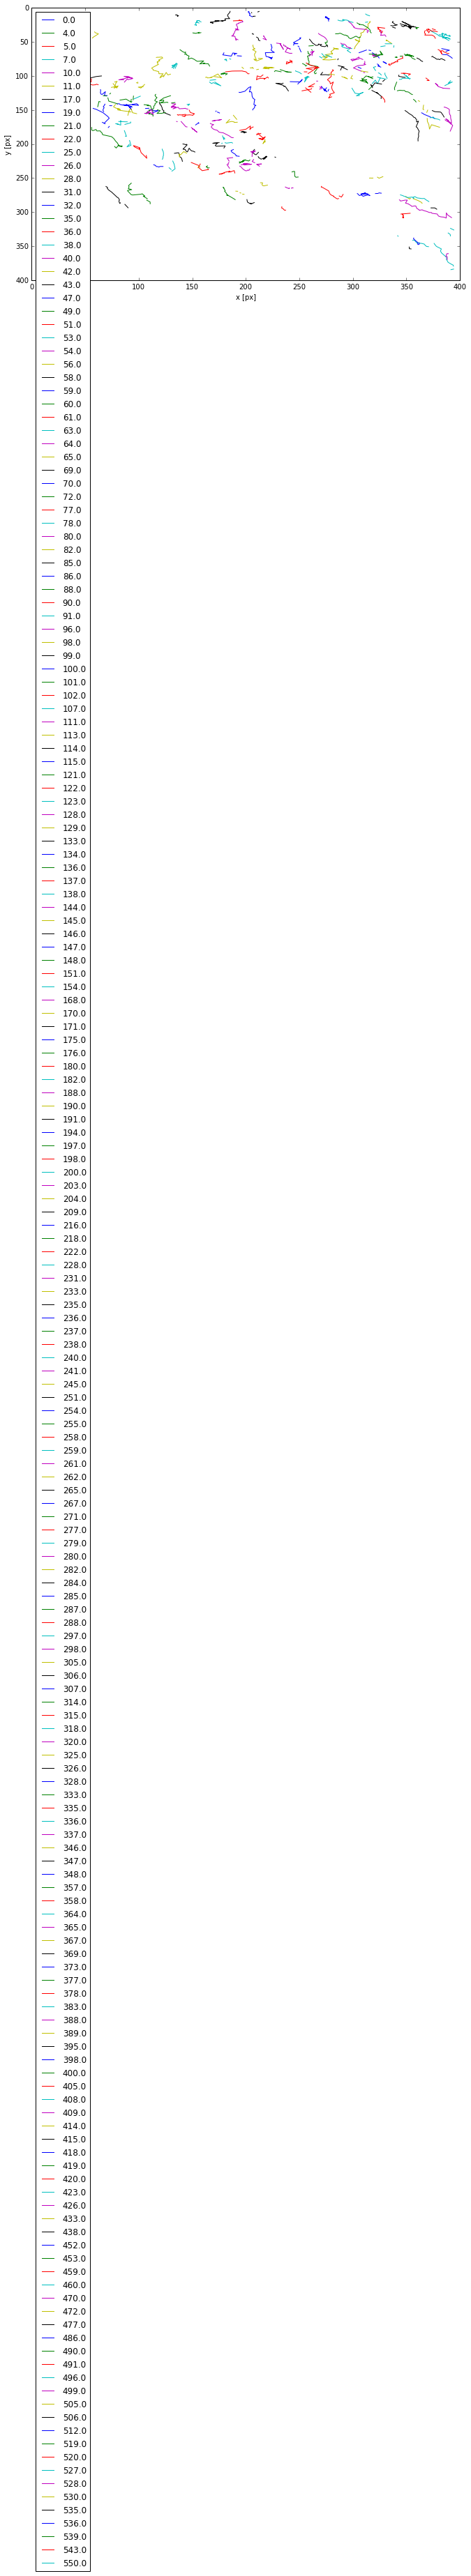

In [385]:
fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t1)

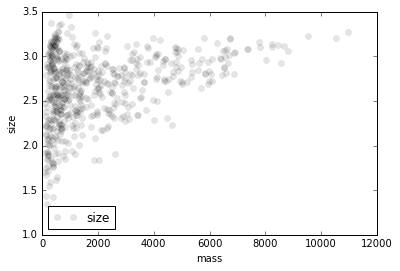

In [386]:
#..Look at appearance... ?
plt.figure()
tp.mass_size(t.groupby('particle').mean())  # convenience function -- just plots size vs. mass

### Try fancy predictive tracking

In [12]:
import trackpy.predict

In [13]:
#..Track with prediction?
pred = trackpy.predict.NearestVelocityPredict()
t = pred.link_df(f, 9, memory=3)

Frame 114: 12 trajectories present


In [14]:
t1 = tp.filter_stubs(t, 6)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 247)
('After:', 81)


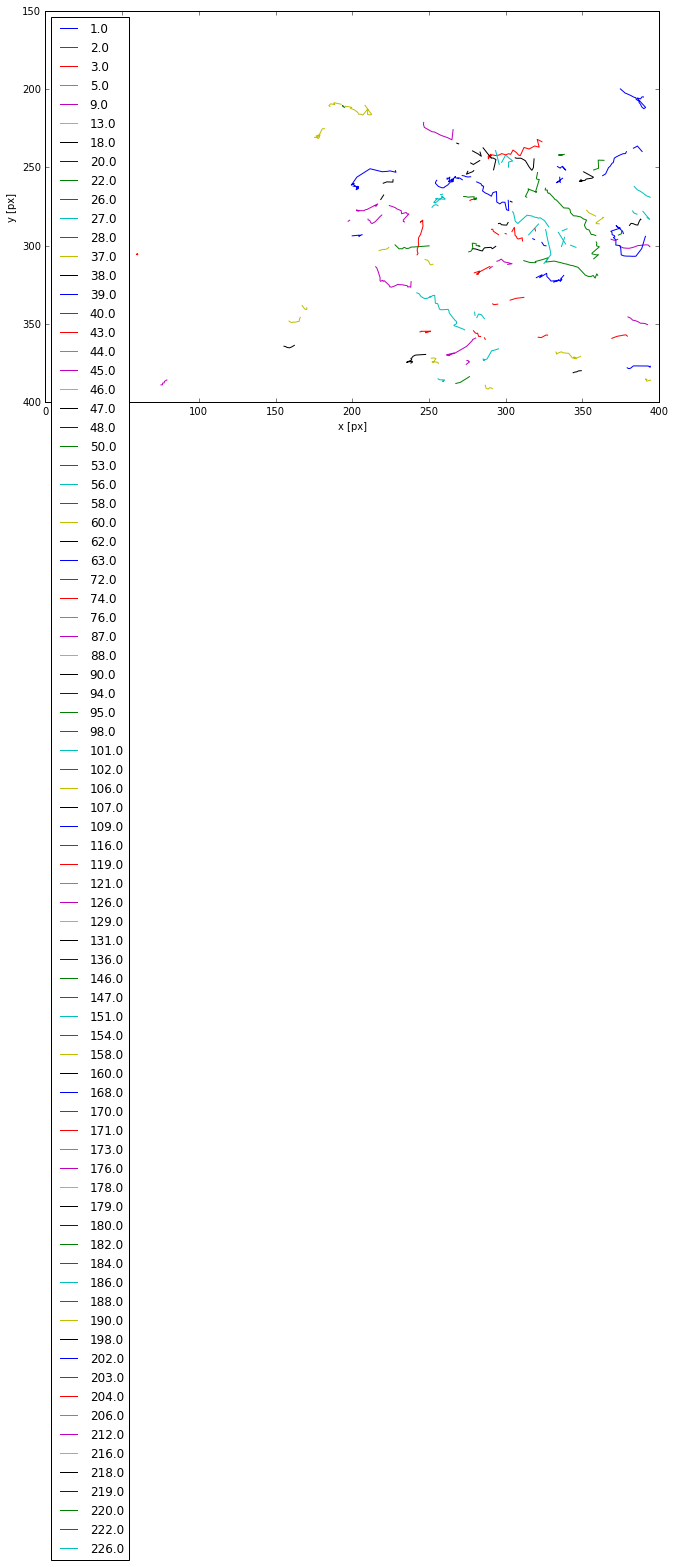

In [15]:

fig = plt.figure(figsize=(11,7))
#ax=fig.add_subplot(111)
ax = tp.plot_traj(t1)

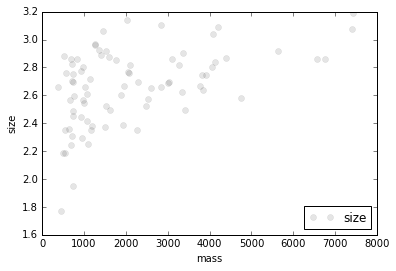

In [16]:
#..Look at appearance... ?
plt.figure()
tp.mass_size(t1.groupby('particle').mean())  # convenience function -- just plots size vs. mass

In [17]:
print t.particle.min(),t.particle.max()
print t1.particle.min(),t1.particle.max()

0.0 246.0
1.0 226.0


(array([ 210.,  231.,  160.,  122.,  124.,   78.,   64.,   69.,   69.,
          60.,   38.,   46.,   36.,   43.,   56.,   41.,   39.,   36.,
          33.,   36.,   45.,   28.,   28.,   21.,   39.,   28.,   36.,
          39.,   24.,   30.,   17.,   19.,   24.,   19.,    7.,    5.,
           4.,    5.,    1.,    2.]),
 array([   102.34066902,    439.06812967,    775.79559031,   1112.52305096,
          1449.2505116 ,   1785.97797225,   2122.7054329 ,   2459.43289354,
          2796.16035419,   3132.88781483,   3469.61527548,   3806.34273613,
          4143.07019677,   4479.79765742,   4816.52511806,   5153.25257871,
          5489.98003935,   5826.7075    ,   6163.43496065,   6500.16242129,
          6836.88988194,   7173.61734258,   7510.34480323,   7847.07226387,
          8183.79972452,   8520.52718517,   8857.25464581,   9193.98210646,
          9530.7095671 ,   9867.43702775,  10204.1644884 ,  10540.89194904,
         10877.61940969,  11214.34687033,  11551.07433098,  11887.8017

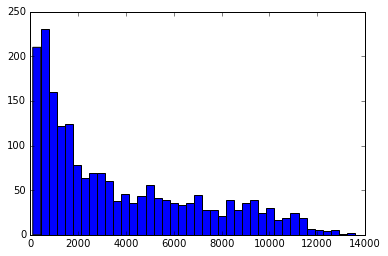

In [22]:
#..Let's just look at what the histogram of "mass" looks like -- we might later use this to only
#..look at "meaningful" KDP columns, or the like.
plt.hist(t1.mass,bins=40)

## Code that loops over trajectories, analyzes and plots is shown below!
This is an amalgamem of code from plot_houston_lma and kdp_cell_tracker. At some point I may integrate an automatic html generator from html_mc3e_stratiform, to automate the generation of html files for animation. We will see!

In [ ]:
#..Some parameters
dist_to_khgx_thresh = 120000.    #.. (m)
mask_rhothresh = 0.8
mask_dbzthresh = 15.
distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
kdpthr=0.5
zdrthr=0.75

#..This removes zero-length cells (or missing particle numbers) and makes a nice list of particle numbers
#..that can be used in the next thingy  ..cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max()+1)):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)
print numpart
#...
starting_fresh=True   #..Do the initial investigation into available NEXRAD gridded data files
if starting_fresh:
    #..Get a list of radar data files. 
    nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
    #nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
    #lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130608/unzipped/'
    lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130619/'
    yyyymmdd = nexrad_path[-9:-1]
    radfile_start = 'grid00_khgx'
    numfiles = 0
    radfiles = []
    for root,dirs,files in walklevel(nexrad_path,level=0):
        for file in files:
            if file.startswith(radfile_start):
                radfiles.append(file)
                numfiles += 1
    #print radfiles
    radfiles = sorted(radfiles)
    filenm = radfiles[0]

    #..Load up things that don't change file-by-file
    filenm = nexrad_path+radfiles[0]
    base_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10])) -
                     datetime.datetime(1970,1,1)).total_seconds()
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    dist_to_khgx = haversine(radr_lat,radr_lon,lat_grid,lon_grid)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    nc.close()
    #..


xbuf = 50000.
ybuf = 50000.
#for i in range(4):
tnt = 0   #...Track Number True
for i in range(numpart):
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)

    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        continue
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        
        
    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = range(tmin,tmax+1)
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new
        
    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for i in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[i],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    
    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]
        
        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        #..make histogram info from lighting
        lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
        if jj==0:
            lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
        else:
            lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))
        
        #..Now get pol radar statistics
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*zgrid
        zdr_pe = zdr_proc*zgrid
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            kdp_pet = kdp_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
            zdr_pet = zdr_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]
        

    #..Loop over all the time indices and... something
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #print 'i,j = ', i,j
        #if (len(t1.x[(t1.particle==partnumlist[i])&(t1.frame==j)])) #..Make sure length ~= 0

        #..Paste below from particle-following code from plot_houston_lma
        #..First let's get the basics -- horizontal and vertical slices following the action

        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[jj]
        maxlon = lon_track[jj]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]

        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        
        fig = plt.figure(figsize=[14,11])
        gs = gridspec.GridSpec(3, 3,width_ratios=[5,2,2])

        ax0 = plt.subplot(gs[0:2,0:1])

        m = Basemap(width=200000,height=180000,projection='lcc',
                resolution='i',lon_0 =maxlon,lat_0=maxlat,lat_1=28.,lat_2=32.)
        parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
        meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
        #m.bluemarble()
        #m.shadedrelief()
        #m.etopo()
        m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
        m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
        m.tissot(maxlon,maxlat,10.8/60.,100,edgecolor='g',facecolor='none')
        m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
        m.drawstates(color='k')
        m.drawparallels(parallels,color='k',labels=[True,False,False,False])
        m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
        m.drawcoastlines()
        #..
        im1 = m.pcolormesh(lon_grid,lat_grid,kdp_int,cmap=cm.CMRmap_r,
                       latlon=True,vmin=0.,vmax=5.)
        m.scatter(sub_lon,sub_lat,s=20.,c=sub_color,alpha=.5,latlon=True,edgecolor='none',cmap=cm.cool,
                 vmin=0.,vmax=6.)        #im1 = m.pcolormesh(lon_grid,lat_grid,zhh[4,:,:],vmin=0.,vmax=64.,latlon=True)
        #..
        ax1 = plt.subplot(gs[1])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20],kdp[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        plt.title('KDP (deg/km) S-N')


        ax2 = plt.subplot(gs[1,1])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20],zdr_proc[0:19,cent_idx[0]-15:cent_idx[0]+15,cent_idx[1]],
                           cmap=pcm.RefDiff,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_y)/1000.,ssub_alt,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        plt.title('ZDR (dB) S-N')

        ax1 = plt.subplot(gs[2])
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)
        #print np.argmin(dist_to_center)
        cent_idx = np.unravel_index(np.argmin(dist_to_center), dist_to_center.shape)
        im2=ax1.pcolormesh(np.arange(-15,15.3,1),ze[0:20],kdp[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RRate11,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_x)/1000.,ssub_alt,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax1.set_ylim(0,10000)
        ax1.set_xlim(-15,15)
        plt.colorbar(im2)
        plt.title('KDP (deg/km) W-E')


        ax2 = plt.subplot(gs[1,2])
        im3=ax2.pcolormesh(np.arange(-15,15.3,1),ze[0:20],zdr_proc[0:19,cent_idx[0],cent_idx[1]-15:cent_idx[1]+15],
                           cmap=pcm.RefDiff,vmin=-.2,vmax=2.)
        plt.scatter(np.array(ssub_x)/1000.,ssub_alt,s=20.,c=ssub_color,alpha=.4,edgecolor='none',cmap=cm.pink_r,
                 vmin=0.,vmax=6.)
        ax2.set_ylim(0,10000)
        ax2.set_xlim(-15,15)
        plt.colorbar(im3)
        plt.title('ZDR (dB) W-E')

        #plt.suptitle(round(str(nex_hod_chop[j-tmin]),2))
        
        ax6 = plt.subplot(gs[6])
        pm = plt.pcolormesh(hod_chop_edge,be,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.)
        ax6.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax6.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax6.set_ylim(be[0],be[-1])
        ax6.set_xlabel('Hour of Day (UTC)')
        ax6.set_ylabel('Height (m)')
        plt.colorbar(pm)
        ax6a = ax6.twinx()
        ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
        ax6a.set_ylim(0.,100.)
        plt.title('LMA flash density (flashes min-1)')
        #..
        #kdptop = fl_data['kdptop']
        #zdrtop = fl_data['zdrtop']
        ax7 = plt.subplot(gs[2,1:])
        #ax7.step(hod_chop_edge[1:],kdptop,'k:')
        #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
        ax7.plot(nex_hod_chop,kdptop,'k',label='kdp col top',alpha=.3)
        ax7.plot(nex_hod_chop,zdrtop,'r',label='zdr col top',alpha=.3)
        ax7.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax7.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7.set_ylim(3000.,12000.)
        ax7.set_ylabel('Height (m)')
        ax7a = ax7.twinx()
        #kdp_pet_all = fl_data['kdp_pet_all']
        #zdr_pet_all = fl_data['zdr_pet_all']
        #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
        #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
        ax7a.plot(nex_hod_chop,kdp_pet_all,'k',alpha=.9,lw=2,label='kdp PE')
        ax7a.plot(nex_hod_chop,zdr_pet_all,'r',alpha=.9,lw=2,label='zdr PE')
        ax7a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7a.set_ylabel('KDP/ZDR Pot. Energy')
        plt.legend()
        
        #plt.suptitle('Houston KDP follow '+str(tnt)+', June 8 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
        plt.suptitle('Houston KDP follow '+str(tnt)+', June 19 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
                  fontsize=16,fontweight='bold')

        opath = '/home/mvanlier/mvanlier/plot_dump/houston_tracking/'+yyyymmdd+'/'
        fig.savefig(opath+'khgx_track_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(j-tmin).zfill(2)+'.png')

        fig.clf()
        plt.close(fig)
            

81
particles plotted =  1
number of steps in track =  23 , should be = 24
particles plotted =  2
all is well, no gaps in the tracking, numsteps =  6
particles plotted =  3
number of steps in track =  12 , should be = 14
particles plotted =  4
number of steps in track =  12 , should be = 14
particles plotted =  5
all is well, no gaps in the tracking, numsteps =  7
particles plotted =  6
number of steps in track =  27 , should be = 30
isempty
isempty
particles plotted =  7
number of steps in track =  13 , should be = 17
particles plotted =  8
number of steps in track =  6 , should be = 9
particles plotted =  9
number of steps in track =  7 , should be = 8
particles plotted =  10
number of steps in track =  15 , should be = 17
particles plotted =  11
all is well, no gaps in the tracking, numsteps =  16
particles plotted = 

In [22]:
#..Some parameters
dist_to_khgx_thresh = 120000.    #.. (m)
mask_rhothresh = 0.8
mask_dbzthresh = 15.
distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
kdpthr=0.5
zdrthr=0.75

#..Now a quick scatter-plot code. Requires the previous cell to be run first
xbuf = 50000.
ybuf = 50000.
distradius=10000.                #..When collecting statistics around KDP col, this is the radius used
#for i in range(4):
tnt = 0   #...Track Number True

#..This removes zero-length cells (or missing particle numbers) and makes a nice list of particle numbers
#..that can be used in the next thingy  ..cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max()+1)):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)
print numpart
#...
starting_fresh=True   #..Do the initial investigation into available NEXRAD gridded data files
if starting_fresh:
    #..Get a list of radar data files. 
    nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
    #nexrad_path = '/home/mvanlier/mvanlier/nexrad_khgx/20130608/'
    #lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130608/unzipped/'
    lmapath    = '/home/mvanlier/mvanlier/lma_houston/old_folders/130619/'
    yyyymmdd = nexrad_path[-9:-1]
    radfile_start = 'grid00_khgx'
    numfiles = 0
    radfiles = []
    for root,dirs,files in walklevel(nexrad_path,level=0):
        for file in files:
            if file.startswith(radfile_start):
                radfiles.append(file)
                numfiles += 1
    #print radfiles
    radfiles = sorted(radfiles)
    filenm = radfiles[0]

    #..Load up things that don't change file-by-file
    filenm = nexrad_path+radfiles[0]
    base_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10])) -
                     datetime.datetime(1970,1,1)).total_seconds()
    nc = Dataset(filenm,'r')
    xd = nc.variables['x_disp'][:]
    yd = nc.variables['y_disp'][:]
    zd = nc.variables['z_disp'][:]
    #..Make vectors of cell edges
    xe = make_edge_vec(xd)
    ye = make_edge_vec(yd)
    ze = make_edge_vec(zd)
    alt= zd + zsfc
    alte=ze + zsfc
    #..Get lat/lon from dx,dy
    lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
    dist_to_khgx = haversine(radr_lat,radr_lon,lat_grid,lon_grid)
    #..
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    nc.close()

for i in range(numpart):
    #..Set the start/end indices for the full timerange
    nex_hod_chop = []
    tmin = t1.frame[t1.particle==partnumlist[i]].min()
    tmax = t1.frame[t1.particle==partnumlist[i]].max()
    #print 'tmin,tmax = ',tmin,tmax
    nt = tmax-tmin+1
    ja = 0
    #..Get a list of HOD
    for j in xrange(tmin,tmax+1):
        filenm = radfiles[j]
        rad_epoch = (datetime.datetime(int(filenm[-18:-14]),int(filenm[-14:-12]),int(filenm[-12:-10]),
                                       int(filenm[-9:-7]),int(filenm[-7:-5]),int(filenm[-5:-3])) -
                     datetime.datetime(1970,1,1)).total_seconds()
        nex_hod_chop = np.r_[nex_hod_chop,rad_epoch]
    nex_hod_chop = (nex_hod_chop - base_epoch)/3600.    #..s -> hr
    hod_chop_edge = make_edge_vec(nex_hod_chop)

    
    #..Pull together strings, time, lat, and lon, to allow for analysis to follow
    logcon = t1.particle==partnumlist[i]
    tidx = t1.index[logcon].values
    xidx = (np.around(t1.x[logcon].values)).astype(int)
    yidx = (np.around(t1.y[logcon].values)).astype(int)
    lon_track = lon_grid[[yidx,xidx]]
    lat_track = lat_grid[[yidx,xidx]]
    
    av_dist_of_track = np.mean(dist_to_khgx[[yidx,xidx]])
    
    if av_dist_of_track>dist_to_khgx_thresh:
        continue
    else:
        tnt += 1
        print 'particles plotted = ',tnt
        
        
    #..Make sure no time indices are being skipped. If they are, do an interpolation to reconstruct
    #..where the things should be going
    if (tidx.shape[0]==nex_hod_chop.shape[0]):
        print 'all is well, no gaps in the tracking, numsteps = ',nex_hod_chop.shape[0]
    else:
        print 'number of steps in track = ',tidx.shape[0],', should be =',nex_hod_chop.shape[0]
        tidx_new = range(tmin,tmax+1)
        f = interpolate.interp1d(tidx,t1.x[logcon].values)
        xidx = (np.around(f(tidx_new))).astype(int)
        f = interpolate.interp1d(tidx,t1.y[logcon].values)
        yidx = (np.around(f(tidx_new))).astype(int)
        lat_track = lat_grid[[yidx,xidx]]
        lon_track = lon_grid[[yidx,xidx]]
        tidx = tidx_new
        
    #..Load LMA lightning data
    if not(lmapath):
        raise ValueError('No LMA path specified')
    lyt_files = []
    numfiles  = 0
    for root,dirs,files in walklevel(lmapath,level=0):
        for file in files:
            if file.startswith('flash_start'):
                lyt_files.append(file)
                numfiles += 1
    lyt_files = sorted(lyt_files)
    #..Loop over all files, string flash information together into one big array
    fl_raw = np.loadtxt(lmapath+lyt_files[0],ndmin=2)
    for i in range(1,numfiles):
        fl_raw = np.vstack((fl_raw,np.loadtxt(basepath+midpath+lyt_files[i],ndmin=2)))
    fl_raw[:,0] = fl_raw[:,0]/3600. #..sod -> hod
    
    
    
    #..Do a prior loop to tabulate statistics
    kdp_sum_all =np.array([])
    zdr_sum_all =np.array([])
    kdp_99p_all =np.array([])
    zdr_99p_all =np.array([])
    kdp_pet_all =np.array([])
    zdr_pet_all =np.array([])
    kdptop = []
    zdrtop = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        t_s = hod_chop_edge[jj]
        t_e = hod_chop_edge[jj+1]
        
        #..Chop down lightning data
        logcon = np.logical_and(fl_raw[:,0]>t_s-.1,fl_raw[:,0]<t_e) #..6 mins before
        #logcon = np.logical_and(fl_raw[:,0]>t_s,fl_raw[:,0]<t_e)
        sub_tim = fl_raw[:,0][logcon]
        sub_lat = fl_raw[:,1][logcon]
        sub_lon = fl_raw[:,2][logcon]
        sub_alt = fl_raw[:,3][logcon]
        sub_color = (t_e-sub_tim)*60. #..to mins...
        #..Make further cut based on 
        sub_dist = haversine(maxlat,maxlon,sub_lat,sub_lon)        
        logcon = sub_dist<distradius
        ssub_tim = sub_tim[logcon]
        ssub_lat = sub_lat[logcon]
        ssub_lon = sub_lon[logcon]
        ssub_alt = sub_alt[logcon]
        ssub_color = sub_color[logcon]
        ssub_x,ssub_y = xy_from_latlon(ssub_lat,ssub_lon,maxlat,maxlon)
        #..make histogram info from lighting
        lma_zhist,be = np.histogram(ssub_alt,bins=np.arange(0.,15000.,1000.))
        if jj==0:
            lma_hall = lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))
        else:
            lma_hall = np.vstack((lma_hall,lma_zhist/(60.*(hod_chop_edge[jj+1]-hod_chop_edge[jj]))))
        
        #..Now get pol radar statistics
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_99p = np.percentile(kdp_proc[9:15,logconi],95.)
        zdr_99p = np.percentile(zdr_proc[9:15,logconi],95.)
        #print kdp_99p
        logconk = np.logical_and(logconi,kdp_int>kdp_99p)
        kdp_sum = kdp_proc[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
        kdp_pe = kdp_proc*zgrid
        zdr_pe = zdr_proc*zgrid
        if not(bool(vol_ones[9:15,logconk].sum()>0.)):
            print 'isempty'
            kdp_sum = -99.
            zdr_sum = -99.
            kdp_pet = 0.
            zdr_pet = 0.
        else:
            zdr_sum = zdr[9:15,logconk].sum()/vol_ones[9:15,logconk].sum()
            kdp_pet = kdp_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
            zdr_pet = zdr_pe[9:17,logconk].sum()/vol_ones[9:17,logconk].sum()
        try:
            kdp_sum_all = np.r_[kdp_sum_all,kdp_sum]
        except ValueError:
            kdp_sum_all = np.r_[kdp_sum_all,-99.]
        try:
            zdr_sum_all = np.r_[zdr_sum_all,zdr_sum]
        except ValueError:
            zdr_sum_all = np.r_[zdr_sum_all,-99.]
        try:
            kdp_pet_all = np.r_[kdp_pet_all,kdp_pet]
        except ValueError:
            kdp_pet_all = np.r_[kdp_pet_all,-99.]
        try:
            zdr_pet_all = np.r_[zdr_pet_all,zdr_pet]
        except ValueError:
            zdr_pet_all = np.r_[zdr_pet_all,-99.]
        kdp_99p_all = np.r_[kdp_99p_all,kdp_99p]
        zdr_99p_all = np.r_[zdr_99p_all,zdr_99p]
        if (zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])].any()):
            kdptop = np.r_[kdptop,np.max(zgrid[np.logical_and(kdp_proc>kdpthr,logconi[None,...])])]
        else:
            kdptop = np.r_[kdptop,0.]
        if (zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))].any()):
            zdrtop = np.r_[zdrtop,max(zgrid[np.logical_and(zgrid<9500.,np.logical_and(zdr_proc>zdrthr,
                                                    np.logical_and(logconi[None,...],zdr_grad<0.)))])]
        else:
            zdrtop = np.r_[zdrtop,0.]
    
    #..Do a prior loop to tabulate statistics
#     kdp_sum_all =np.array([])
#     zdr_sum_all =np.array([])
#     kdp_99p_all =np.array([])
#     zdr_99p_all =np.array([])
#     kdp_pet_all =np.array([])
#     zdr_pet_all =np.array([])
#     kdptop = []
#     zdrtop = []
    for j in range(tmin,tmax+1):
        jj = j-tmin
        #..The "centerpoint" for the action will be maxlon,maxlat (too lazy to change name)
        maxlat = lat_track[j-tmin]
        maxlon = lon_track[j-tmin]
        dist_to_center = haversine(lat_grid,lon_grid,maxlat,maxlon)

        filee = nexrad_path+radfiles[j]
        #print filee
        nc = Dataset(filee,'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['kdp'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()

        #..
        logconi = dist_to_center<distradius
        kdp_proc = copy.deepcopy(kdp)
        kdp_proc = np.ma.masked_values(kdp_proc,-9999.)
        kdp_proc = np.ma.masked_where(rho<mask_rhothresh,kdp_proc)
        #kdp_proc = np.ma.masked_where(zhh<15.,kdp_proc)
        kdp_proc = np.ma.masked_where(zhh<mask_dbzthresh,kdp_proc)
        kdp_int = kdp_proc[9:15,:,:].sum(axis=0)
        #..
        zdr_proc = copy.deepcopy(zdr)
        zdr_proc = np.ma.masked_values(zdr_proc,-9999.)
        zdr_grad = 0.*copy.deepcopy(zdr_proc)
        zdr_grad[0:-1,:,:] = zdr_proc[1:,:,:]-zdr_proc[0:-1,:,:]
        
        
        fig = plt.figure(figsize=(10,9))
        gs  = gridspec.GridSpec(6, 2,width_ratios=[1,3])
        #..
        ax = fig.add_subplot(gs[0:2,0])
        plt.scatter(kdp_proc[14:19,logconi],zdr_proc[14:19,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('7-9 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax = fig.add_subplot(gs[2:4,0])
        plt.scatter(kdp_proc[10:14,logconi],zdr_proc[10:14,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('5-7 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax = fig.add_subplot(gs[4:,0])
        plt.scatter(kdp_proc[6:10,logconi],zdr_proc[6:10,logconi],s=50,c='k',alpha=.1,edgecolor='none')
        plt.plot([0.,2.],[0.,0.],'r:')
        ax.set_xlim(0,2.)
        ax.set_ylim(-1,3.)
        plt.title('3-5 km',fontsize=12,fontweight='bold')
        ax.set_xlabel('KDP',fontsize=11)
        ax.set_ylabel('ZDR',fontsize=11)
        #..
        ax6 = fig.add_subplot(gs[0:3,1])
        pm = plt.pcolormesh(hod_chop_edge,be,lma_hall.T,cmap=cm.cubehelix_r,vmin=0.,vmax=20.)
        ax6.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax6.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax6.set_ylim(be[0],be[-1])
        ax6.set_xlabel('Hour of Day (UTC)')
        ax6.set_ylabel('Height (m)')
        plt.colorbar(pm)
        ax6a = ax6.twinx()
        ax6a.step(hod_chop_edge[1:],lma_hall.sum(axis=1),'k',where='pre',linewidth=2,alpha=.4)
        ax6a.set_ylim(0.,100.)
        plt.title('LMA flash density (flashes min-1)')
        #..
        #kdptop = fl_data['kdptop']
        #zdrtop = fl_data['zdrtop']
        ax7 = fig.add_subplot(gs[3:,1])
        #ax7.step(hod_chop_edge[1:],kdptop,'k:')
        #ax7.step(hod_chop_edge[1:],zdrtop,'r:')
        ax7.plot(nex_hod_chop,kdptop,'k',label='kdp col top',alpha=.3)
        ax7.plot(nex_hod_chop,zdrtop,'r',label='zdr col top',alpha=.3)
        ax7.plot([nex_hod_chop[jj],nex_hod_chop[jj]],[0,16000.],'r--')
        ax7.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7.set_ylim(3000.,12000.)
        ax7.set_ylabel('Height (m)')
        ax7.set_xlabel('Hour of Day (UTC)')
        ax7a = ax7.twinx()
        #kdp_pet_all = fl_data['kdp_pet_all']
        #zdr_pet_all = fl_data['zdr_pet_all']
        #ax7a.step(hod_chop_edge[1:],kdp_pet_all,'k',alpha=.5,lw=2)
        #ax7a.step(hod_chop_edge[1:],zdr_pet_all,'r',alpha=.5,lw=2)
        ax7a.plot(nex_hod_chop,kdp_pet_all,'k',alpha=.9,lw=2,label='kdp PE')
        ax7a.plot(nex_hod_chop,zdr_pet_all,'r',alpha=.9,lw=2,label='zdr PE')
        ax7a.set_xlim(hod_chop_edge[0],hod_chop_edge[-1])
        ax7a.set_ylabel('KDP/ZDR Pot. Energy')
        plt.title('KDP/ZDR Column Pot. Energy & Height (gray)',fontsize=12)
        #..
        gs.update(hspace=1.5)
        #..
        plt.suptitle('Houston KDP scatter '+str(tnt)+', June 19 2013, HOD = '+str(round(nex_hod_chop[jj],2))+' UTC',
                  fontsize=16,fontweight='bold')
        opath = '/home/mvanlier/mvanlier/plot_dump/houston_tracking/'+yyyymmdd+'/'
        fig.savefig(opath+'khgx_scatter_'+yyyymmdd+'_'+str(tnt).zfill(3)+'_'+str(jj).zfill(2)+'.png')
        fig.clf()
        plt.close(fig)

81
particles plotted =  1
number of steps in track =  23 , should be = 24
particles plotted =  2
all is well, no gaps in the tracking, numsteps =  6
particles plotted =  3
number of steps in track =  12 , should be = 14
particles plotted =  4
number of steps in track =  12 , should be = 14
particles plotted =  5
all is well, no gaps in the tracking, numsteps =  7
particles plotted =  6
number of steps in track =  27 , should be = 30
isempty
isempty
particles plotted =  7
number of steps in track =  13 , should be = 17
particles plotted =  8
number of steps in track =  6 , should be = 9
particles plotted =  9
number of steps in track =  7 , should be = 8
particles plotted =  10
number of steps in track =  15 , should be = 17
particles plotted =  11
all is well, no gaps in the tracking, numsteps =  16
particles plotted =  12
number of steps in track =  37 , should be = 40
particles plotted =  13
number of steps in track =  15 , should be = 16
particles plotted =  14
all is well, no gaps 

In [1]:
print lon_grid[[45,46,47],[46,47,48]]
print np.array([[45,46,47],[46,47,48]]).shape

NameError: name 'lon_grid' is not defined

<type 'numpy.ndarray'>
(27,)
[306 308 318 318 320 321 320 324 324 325 329]
[63 63 66 66 68 69 70 71 73 74 79]
[ 9 10 12 13 14 15 16 17 18 19 21]
(2, 11)
(400, 400)
avg =  -93.8501801906
[ 28.22884619  28.22867782  28.25492504  28.25492504  28.27282834
  28.28177875  28.29091886  28.29957984  28.31767014  28.32661719
  28.37144207]
[-93.98733308 -93.96690858 -93.86447673 -93.86447673 -93.84383681
 -93.8335142  -93.84362605 -93.80264472 -93.80242673 -93.79209613
 -93.75064234]


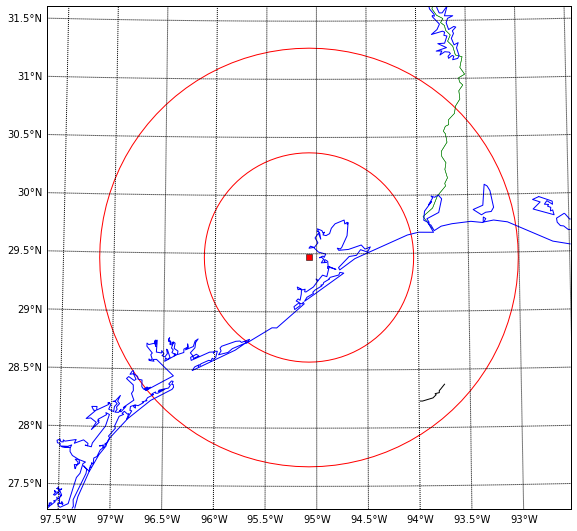

In [400]:
#print t1.x[t1.particle==20].as_matrix
xii = (np.around(t1.x[t1.particle==20].values)).astype(int)
yii = (np.around(t1.y[t1.particle==20].values)).astype(int)
test1 = t1.index[t1.particle==20].values
print type(test)
print test.shape
print xii
print yii
print test1
xyii = np.vstack((xii,yii))
print xyii.shape
#..
print lat_grid.shape
lattrack = lat_grid[[yii,xii]]
lontrack = lon_grid[[yii,xii]]
print 'avg = ', np.mean(lon_grid[[yii,xii]])
print lattrack
print lontrack
#..
fig=plt.figure(figsize=(10,9))
m = Basemap(width=500000,height=480000,projection='lcc',
                resolution='i',lon_0 =radr_lon,lat_0=radr_lat,lat_1=28.,lat_2=32.)
parallels = np.arange(round(radr_lat,0)-5.,round(radr_lat,0)+5,.5)
meridians = np.arange(round(radr_lon,0)-5,round(radr_lon,0)+5,.5)
#m.bluemarble()
#m.shadedrelief()
#m.etopo()

m.tissot(radr_lon,radr_lat,108./60.,100,edgecolor='r',facecolor='none')
m.tissot(radr_lon,radr_lat,108./120.,100,edgecolor='r',facecolor='none')
m.plot(radr_lon,radr_lat,latlon=True,marker='s',color='r')
m.drawparallels(parallels,color='k',labels=[True,False,False,False])
m.drawmeridians(meridians,color='k',labels=[False,False,False,True])
m.drawstates(color='g')
m.drawcoastlines(color='b')
m.plot(lontrack,lattrack,'k',latlon=True)

#..

# JUNKY STUFF BELOW -- NONOPERATIONAL CODE STUBS!

In [ ]:
#..Saving this for later -- a progress bar!
from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=100)
display(f)
for i in xrange(100):
   sleep(0.1)
   f.value = i

In [ ]:
#..not sure what this does, cut from trackpy website

for pid in tr.particle.unique():
    plot(tr.x[tr.particle == pid],
                 tr.y[tr.particle == pid], 'r-')
    axis('equal'); ylim(-11, 11)

numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max())):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)

In [ ]:
#..Not sure what this is from.. .cut from kdp_cell_tracker
numpart = 0
partnumlist = []
for i in range(int(t1.particle.min()),int(t1.particle.max())):
    if len(t1[t1.particle==i])!=0:
        numpart += 1
        partnumlist.append(i)